## Logistic functions

In [21]:
# As in the paper, these "safe" logistic gradient functions are taken from 
# http://fa.bianp.net/blog/2019/evaluate_logistic/

import scipy
import numpy as np

import numpy.linalg as la
from sklearn.utils.extmath import safe_sparse_dot

def safe_sparse_add(a, b):
    if scipy.sparse.issparse(a) and scipy.sparse.issparse(b):
        # both are sparse, keep the result sparse
        return a + b
    else:
        # on of them is non-sparse, convert
        # everything to dense.
        if scipy.sparse.issparse(a):
            a = a.toarray()
            if a.ndim == 2 and b.ndim == 1:
                b.ravel()
        elif scipy.sparse.issparse(b):
            b = b.toarray()
            if b.ndim == 2 and a.ndim == 1:
                b = b.ravel()
        return a + b
    
    
def logsig(x):
    out = np.zeros_like(x)
    idx0 = x < -33
    out[idx0] = x[idx0]
    idx1 = (x >= -33) & (x < -18)
    out[idx1] = x[idx1] - np.exp(x[idx1])
    idx2 = (x >= -18) & (x < 37)
    out[idx2] = -np.log1p(np.exp(-x[idx2]))
    idx3 = x >= 37
    out[idx3] = -np.exp(-x[idx3])
    return out


def logistic_loss(w, X, y, gamma):
    z = np.dot(X, w)
    y = np.asarray(y)
    return np.mean((1-y)*z - logsig(z)) + gamma/2 * la.norm(w)**2


def logistic_gradient(w, X, y_, gamma, normalize=True):
    y = (y_+1) / 2 if -1 in y_ else y_
    activation = scipy.special.expit(safe_sparse_dot(X, w, dense_output=True).ravel())
    grad = safe_sparse_add(X.T.dot(activation - y) / X.shape[0], gamma * w)
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(y)

def logistic_gradient_stochastic(i, w, X, y_, gamma, normalize=True):
    y = (y_+1) / 2 if -1 in y_ else y_
    activation = scipy.special.expit(safe_sparse_dot(X[i], w, dense_output=True).ravel())
    grad = safe_sparse_add(X[i] * (activation - y[i]), gamma * w)
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(y)

def logistic_gradient_minibatch(i, i2, w, X, y_, gamma, normalize=True):
    y = (y_+1) / 2 if -1 in y_ else y_
    activation = scipy.special.expit(safe_sparse_dot(X[i:i2], w, dense_output=True).ravel())
    if i == i2:
        grad = safe_sparse_add(X[i] * (activation - y[i]), gamma * w)
    else:
        grad = safe_sparse_add(X[i:i2].T.dot(activation - y[i:i2]) / (i2-i), gamma * w)
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(y)

## Algorithms

In [22]:
import numpy as np
import sklearn

def adaptive_gd(X, y, gamma, grad, iters):
    theta = 1e10
    lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    v[1] = v[0] - 1e-10 * grad(v[0], X, y, gamma)
    for k in range(1, iters-1):
        if k % 1000 == 0:
            print("AdGD: {}".format(k))
        grad_vk = grad(v[k], X, y, gamma)
        min_1 = np.sqrt(1 + theta) * lam
        min_2 = 0.5 * np.linalg.norm(v[k] - v[k-1]) / np.linalg.norm(grad_vk - grad(v[k-1], X, y, gamma))
        prev_lam = lam
        lam = min(min_1, min_2)
        v[k+1] = v[k] - lam * grad_vk
        theta = lam/prev_lam
    return v


def gd(X, y, gamma, grad, iters, alpha):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    for k in range(1, iters):
        if k % 1000 == 0:
            print("GD: {}".format(k))
        v[k] = v[k-1] - alpha * grad(v[k-1], X, y, gamma)
    return v


def adaptive_gd_nesterov(X, y, gamma, grad, iters):
    theta = 1e10
    Theta = 1e10
    lam = 1
    Lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    v[1] = v[0] - 1e-10 * grad(v[0], X, y, gamma)
    prev_w = 0
    for k in range(1, iters-1):
        if k % 1000 == 0:
            print("AdGD Nesterov: {}".format(k))
        grad_vk = grad(v[k], X, y, gamma)
        grad_div = np.linalg.norm(v[k] - v[k-1]) / np.linalg.norm(grad_vk - grad(v[k-1], X, y, gamma))
        
        min_1 = np.sqrt(1 + theta/2) * lam
        min_2 = 0.5 * grad_div
        Min_1 = np.sqrt(1 + Theta/2) * Lam
        Min_2 = 0.5 * (1/grad_div)
        
        prev_lam = lam
        prev_Lam = Lam
        lam = min(min_1, min_2)
        Lam = min(Min_1, Min_2)
        s = np.sqrt(lam * Lam)
        sq_lam = np.sqrt(1/lam)
        sq_Lam = np.sqrt(Lam)
        
        beta = (sq_lam - sq_Lam) / (sq_lam + sq_Lam)
    
        w = v[k] - lam * grad_vk
        v[k+1] = w + beta * (w - prev_w)
        prev_w = w
        theta = lam/prev_lam
        Theta = Lam/prev_Lam
    return v


def gd_barzilai_borwein(X, y, gamma, grad, iters):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    v[1] = v[0] - 1e-10 * grad(v[0], X, y, gamma)
    end = False
    for k in range(1, iters-1):
        if k % 1000 == 0:
            print("BB: {}".format(k))
        grad_vk = grad(v[k], X, y, gamma)
        grad_diff = grad_vk - grad(v[k-1], X, y, gamma)
        s = np.linalg.norm(grad_diff)**2
        if end:
            v[k+1] = v[k]
        else:
            if abs(s) < 1e-30:
                end = True
                v[k+1] = v[k]
                continue
            lam = ((v[k] - v[k-1]) @ grad_diff) / (s)
            v[k+1] = v[k] - lam * grad_vk
    return v


def gd_polyak(X, y, gamma, grad, iters, f, f_star):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    for k in range(1, iters):
        if k % 1000 == 0:
            print("Polyak: {}".format(k))
        lam = (f(v[k-1], X, y, gamma) - f_star) / np.linalg.norm(grad(v[k-1], X, y, gamma))**2
        v[k] = v[k-1] - lam * grad(v[k-1], X, y, gamma)
    return v


# using grad(x^k) as the descent direction for simplicity
def gd_armijo(X, y, gamma, grad, iters, f, factor, starting_alpha):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    for k in range(1, iters):
        if k % 1000 == 0:
            print("Armijo: {}".format(k))
        alpha = starting_alpha
        obj = f(v[k-1], X, y, gamma)
        grad_vkm = grad(v[k-1], X, y, gamma)
        v_new = v[k-1] - alpha * grad_vkm
        obj_new = f(v_new, X, y, gamma)
        satisfied = obj_new <= obj - alpha * factor * np.linalg.norm(grad_vkm)**2
        while not satisfied:
            alpha = alpha * factor
            v_new = v[k-1] - alpha * grad_vkm
            obj_new = f(v_new, X, y, gamma)
            satisfied = obj_new <= obj - alpha * factor * np.linalg.norm(grad_vkm)**2
        v[k] = v[k-1] - alpha * grad_vkm
    return v


def gd_nesterov_line_search(X, y, gamma, grad, iters):
    pass


def adaptive_gd_stochastic(X, y, gamma, gradi, iters, alpha):
    theta = 1e10
    lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    i = np.random.randint(0, X.shape[0])
    v[1] = v[0] - 1e-10 * gradi(i, v[0], X, y, gamma)
    for k in range(1, iters-1):
        i = np.random.randint(0, X.shape[0])
        grad_vk = gradi(i, v[k], X, y, gamma)
        min_1 = np.sqrt(1 + theta) * lam
        min_2 = alpha * np.linalg.norm(v[k] - v[k-1]) / np.linalg.norm(grad_vk - gradi(i, v[k-1], X, y, gamma))
        prev_lam = lam
        lam = min(min_1, min_2)
        v[k+1] = v[k] - lam * grad_vk
        theta = lam/prev_lam
    return v


def gd_stochastic(X, y, gamma, gradi, iters, alpha):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    for k in range(1, iters):
        i = np.random.randint(0, X.shape[0])
        v[k] = v[k-1] - alpha * gradi(i, v[k-1], X, y, gamma)
    return v


def gd_svrg(X, y, gamma, gradi, grad, iters, alpha, sets):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    full_grad = 0
    vtilde = v[0].copy()
    for k in range(1, iters):
        if (k - 1) % sets == 0:
            full_grad = grad(v[k-1], X, y, gamma)
            vtilde = v[k-1].copy()
        i = np.random.randint(0, X.shape[0])
        v[k] = v[k-1] - alpha * (gradi(i, v[k-1], X, y, gamma) - gradi(i, vtilde, X, y, gamma) + full_grad)
    return v


def adaptive_gd_svrg(X, y, gamma, gradi, grad, iters, alpha, sets):
    theta = 1e10
    lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    i = np.random.randint(0, X.shape[0])
    v[1] = v[0] - 1e-10 * gradi(i, v[0], X, y, gamma)
    full_grad = 0
    vtilde = v[1].copy()
    for k in range(1, iters-1):
        if (k-1) % sets == 0:
            full_grad = grad(v[k], X, y, gamma)
            vtilde = v[k].copy()
        i = np.random.randint(0, X.shape[0])
        grad_vk = gradi(i, v[k], X, y, gamma)
        min_1 = np.sqrt(1 + theta) * lam
        min_2 = alpha * np.linalg.norm(v[k] - v[k-1]) / np.linalg.norm(grad_vk - gradi(i, v[k-1], X, y, gamma))
        prev_lam = lam
        lam = min(min_1, min_2)
        v[k+1] = v[k] - lam * (grad_vk - gradi(i, vtilde, X, y, gamma) + full_grad)
        theta = lam/prev_lam
    return v

def gd_minibatch(X, y, gamma, gradim, iters, alpha, sz):
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    n = X.shape[0] / sz
    for k in range(1, iters):
        vl = v[k-1].copy()
        for i in range(int(n)):
            i2 = max(X.shape[0]-1, i+sz)
            vl = vl - alpha * gradim(i, i2, vl, X, y, gamma)
        v[k] = vl.copy()
        sklearn.utils.shuffle(X, y)
    return v


def adaptive_gd_minibatch(X, y, gamma, gradim, iters, alpha, sz):
    theta = 1e10
    lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    i = 0 #np.random.randint(0, X.shape[0])
    i2 = max(X.shape[0]-1, i + sz)
    v[1] = v[0] - 1e-10 * gradim(i, i2, v[0], X, y, gamma)
    n = X.shape[0]//sz
    for k in range(1, iters-1):
        vnew = v[k].copy()
        vold = v[k-1].copy()    
        for i in range(n):
            i2 = max(X.shape[0]-1, i+sz)
            grad_vnew = gradim(i, i2, vnew, X, y, gamma)
            min_1 = np.sqrt(1 + theta) * lam
            min_2 = alpha * np.linalg.norm(vnew - vold) / np.linalg.norm(grad_vnew - gradim(i, i2, vold, X, y, gamma))
            prev_lam = lam
            lam = min(min_1, min_2)
            vold = vnew
            vnew = vnew - lam * grad_vnew
            theta = lam/prev_lam
        v[k+1] = vnew.copy()
        sklearn.utils.shuffle(X, y)
    return v

def adaptive_gd_svrg_minibatch(X, y, gamma, gradim, grad, iters, alpha, sz):
    theta = 1e10
    lam = 1
    v = np.zeros((iters, X.shape[1]))
    v[0] = 0
    i = 0 #np.random.randint(0, X.shape[0])
    i2 = max(X.shape[0]-1, i + sz)
    v[1] = v[0] - 1e-10 * gradim(i, i2, v[0], X, y, gamma)
    n = X.shape[0]//sz
    for k in range(1, iters-1):
        vnew = v[k].copy()
        full_grad = grad(vnew, X, y, gamma)
        vtilde = vnew.copy()
        vold = v[k-1].copy()    
        for i in range(n):
            i2 = max(X.shape[0]-1, i+sz)
            grad_vnew = gradim(i, i2, vnew, X, y, gamma)
            min_1 = np.sqrt(1 + theta) * lam
            min_2 = alpha * np.linalg.norm(vnew - vold) / np.linalg.norm(grad_vnew - gradim(i, i2, vold, X, y, gamma))
            prev_lam = lam
            lam = min(min_1, min_2)
            vold = vnew
            vnew = vnew - lam * (grad_vnew - gradim(i, i2, vtilde, X, y, gamma) + full_grad)
            theta = lam/prev_lam
        v[k+1] = vnew.copy()
        sklearn.utils.shuffle(X, y)
    return v

## Experiments on Mushrooms Dataset

In [25]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt


SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7.2,4.8))

def get_loss(loss_f, v, iters, X, y, gamma):
    loss = np.zeros(iters)
    for i in range(iters):
        loss[i] = loss_f(v[i], X, y, gamma)
    return loss
        
iters = 3000
data = load_svmlight_file("mushrooms")
X, y = data[0].toarray(), data[1]
numrows = X.shape[0]
y -= 1
# lipschitz constant 
L = 0.25 * np.max(np.linalg.eigvalsh(X.T @ X / X.shape[0]))

gamma = L / (10 * X.shape[0])

loss = []

v_gd = gd(X, y, gamma, logistic_gradient, iters, 1/L)
loss.append(get_loss(logistic_loss, v_gd, iters, X, y, gamma))

v_adaptive = adaptive_gd(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_adaptive, iters, X, y, gamma))

v_ad_nesterov = adaptive_gd_nesterov(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_ad_nesterov, iters, X, y, gamma))

min_loss = np.min([np.min(l) for l in loss])
for l in loss:
    plt.plot(l - min_loss)

plt.yscale("log")
plt.suptitle("Mushrooms: Algorithms")
plt.xlabel("Iteration")
plt.ylabel("$f(x^k) - f^*$")
plt.grid()
plt.legend(["GD", "AdGD", "AdGDaccel"])
# plt.show()
plt.savefig("shroomalgo.png", dpi=500)
plt.clf()

loss = []
v_adaptive = adaptive_gd(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_adaptive, iters, X, y, gamma))

v_bb = gd_barzilai_borwein(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_bb, iters, X, y, gamma))

min_loss = np.min([np.min(l) for l in loss])

v_polyak = gd_polyak(X, y, gamma, logistic_gradient, iters, logistic_loss, min_loss)
loss.append(get_loss(logistic_loss, v_polyak, iters, X, y, gamma))

plt.suptitle("Mushrooms: Step Size Methods")
plt.yscale("log")
for l in loss:
    plt.plot(l - min_loss)
    
plt.xlabel("Iteration")
plt.ylabel("$f(x^k) - f^*$")
plt.grid()

plt.legend(["AdGD", "BB", "Polyak"])
# plt.show()
plt.savefig("shroomstepsize.png", dpi=500)
plt.clf()

GD: 1000
GD: 2000
AdGD: 1000
AdGD: 2000
AdGD Nesterov: 1000
AdGD Nesterov: 2000
AdGD: 1000
AdGD: 2000
BB: 1000
BB: 2000
Polyak: 1000
Polyak: 2000


<Figure size 518.4x345.6 with 0 Axes>

## Experiments on W8a Dataset

Armijo: 1000
Armijo: 2000
Armijo: 3000
Armijo: 4000
Armijo: 5000
Armijo: 6000
Armijo: 7000
AdGD: 1000
AdGD: 2000
AdGD: 3000
AdGD: 4000
AdGD: 5000
AdGD: 6000
AdGD: 7000
AdGD Nesterov: 1000
AdGD Nesterov: 2000
AdGD Nesterov: 3000
AdGD Nesterov: 4000
AdGD Nesterov: 5000
AdGD Nesterov: 6000
AdGD Nesterov: 7000


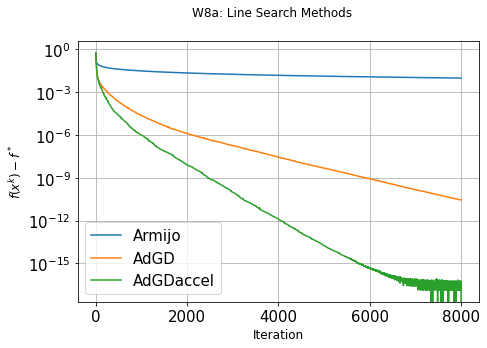

In [28]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7.2,4.8))
def get_loss(loss_f, v, iters, X, y, gamma):
    loss = np.zeros(iters)
    for i in range(iters):
        loss[i] = loss_f(v[i], X, y, gamma)
    return loss
        
iters = 8000
data = load_svmlight_file("w8a")
X, y = data[0].toarray(), data[1]
y += 1
y /= 2
numrows = X.shape[0]

# lipschitz constant 
L = 0.25 * np.max(np.linalg.eigvalsh(X.T @ X / X.shape[0]))

gamma = L / (10 * X.shape[0])

loss = []

v_armijo = gd_armijo(X, y, gamma, logistic_gradient, iters, logistic_loss, 0.5, 1/L)
loss.append(get_loss(logistic_loss, v_armijo, iters, X, y, gamma))

v_adaptive = adaptive_gd(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_adaptive, iters, X, y, gamma))

v_ad_nesterov = adaptive_gd_nesterov(X, y, gamma, logistic_gradient, iters)
loss.append(get_loss(logistic_loss, v_ad_nesterov, iters, X, y, gamma))

min_loss = np.min([np.min(l) for l in loss])
for l in loss:
    plt.plot(l - min_loss)

plt.yscale("log")
plt.suptitle("W8a: Line Search Methods")
plt.xlabel("Iteration")
plt.ylabel("$f(x^k) - f^*$")
plt.grid()
plt.legend(["Armijo", "AdGD", "AdGDaccel", "NesterovLS"])
# plt.show()
plt.savefig("w8alinesearch.png", dpi=500)

## Adaptive Stochastic GD on Mushrooms

In [26]:
plt.clf()
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7.2,4.8))
def get_loss(loss_f, v, iters, X, y, gamma):
    loss = np.zeros(iters)
    for i in range(iters):
        loss[i] = loss_f(v[i], X, y, gamma)
    return loss
        
iters = 1000
data = load_svmlight_file("mushrooms")
X, y = data[0].toarray(), data[1]
numrows = X.shape[0]
y -= 1
# lipschitz constant 
L = 0.25 * np.max(np.linalg.eigvalsh(X.T @ X / X.shape[0]))

gamma = L / (10 * X.shape[0])

loss = []
print(X.shape)
v_gds = gd_stochastic(X, y, gamma, logistic_gradient_stochastic, iters, 1/L)
loss.append(get_loss(logistic_loss, v_gds, iters, X, y, gamma))

v_gdm = gd_minibatch(X, y, gamma, logistic_gradient_minibatch, iters, 1/L, 200)
loss.append(get_loss(logistic_loss, v_gdm, iters, X, y, gamma))

v_agds = adaptive_gd_stochastic(X, y, gamma, logistic_gradient_stochastic, iters, 0.5)
loss.append(get_loss(logistic_loss, v_agds, iters, X, y, gamma))

v_agdm = adaptive_gd_minibatch(X, y, gamma, logistic_gradient_minibatch, iters, 0.5, 200)
loss.append(get_loss(logistic_loss, v_agdm, iters, X, y, gamma))

# v_agdm2 = adaptive_gd_minibatch(X, y, gamma, logistic_gradient_minibatch, iters, 0.5, 4062)
# loss.append(get_loss(logistic_loss, v_agdm2, iters, X, y, gamma))

# v_adaptive = adaptive_gd(X, y, gamma, logistic_gradient, iters)
# loss.append(get_loss(logistic_loss, v_adaptive, iters, X, y, gamma))

min_loss = np.min([np.min(l) for l in loss])
for l in loss:
    plt.plot(l - min_loss)

plt.yscale("log")
plt.suptitle("Stochastic Adaptive GD")
plt.xlabel("Iteration")
plt.ylabel("$f(x^k) - f^*$")
plt.grid()
plt.legend(["SGD", "Minibatch", "AdSGD", "AdMinibatch"], loc="lower right")
# plt.show()
plt.savefig("adaptivesgd.png", dpi=500)
plt.clf()

(8124, 112)


<Figure size 432x288 with 0 Axes>

<Figure size 518.4x345.6 with 0 Axes>

## Adaptive SVRG on Mushrooms

(8124, 112)


<ipython-input-22-6442bb8d4ae5>:254: RuntimeWarning: invalid value encountered in double_scalars
  min_2 = alpha * np.linalg.norm(vnew - vold) / np.linalg.norm(grad_vnew - gradim(i, i2, vold, X, y, gamma))


<Figure size 432x288 with 0 Axes>

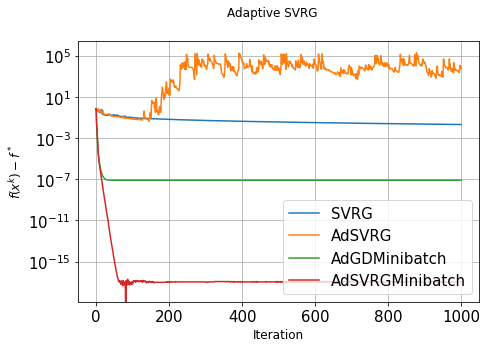

In [27]:
plt.clf()
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7.2,4.8))

def get_loss(loss_f, v, iters, X, y, gamma):
    loss = np.zeros(iters)
    for i in range(iters):
        loss[i] = loss_f(v[i], X, y, gamma)
    return loss
        
iters = 1000
data = load_svmlight_file("mushrooms")
X, y = data[0].toarray(), data[1]
numrows = X.shape[0]
y -= 1
# lipschitz constant 
L = 0.25 * np.max(np.linalg.eigvalsh(X.T @ X / X.shape[0]))

gamma = L / (10 * X.shape[0])

loss = []
print(X.shape)
# v_gds = gd_stochastic(X, y, gamma, logistic_gradient_stochastic, iters, 1/L)
# loss.append(get_loss(logistic_loss, v_gds, iters, X, y, gamma))

v_svrg = gd_svrg(X, y, gamma, logistic_gradient_stochastic, logistic_gradient, iters, 1/L, 20)
loss.append(get_loss(logistic_loss, v_svrg, iters, X, y, gamma))

v_ad_svrg = adaptive_gd_svrg(X, y, gamma, logistic_gradient_stochastic, logistic_gradient, iters, 0.5, 20)
loss.append(get_loss(logistic_loss, v_ad_svrg, iters, X, y, gamma))

v_agdms = adaptive_gd_minibatch(X, y, gamma, logistic_gradient_minibatch, iters, 0.5, 200)
loss.append(get_loss(logistic_loss, v_agdms, iters, X, y, gamma))

v_agdm = adaptive_gd_svrg_minibatch(X, y, gamma, logistic_gradient_minibatch, logistic_gradient, iters, 0.5, 200)
loss.append(get_loss(logistic_loss, v_agdm, iters, X, y, gamma))


min_loss = np.min([np.min(l) for l in loss])
for l in loss:
    plt.plot(l - min_loss)

plt.yscale("log")
plt.suptitle("Adaptive SVRG")
plt.xlabel("Iteration")
plt.ylabel("$f(x^k) - f^*$")
plt.grid()
plt.legend(["SVRG", "AdSVRG", "AdGDMinibatch", "AdSVRGMinibatch"], loc="lower right")
# plt.show()
plt.savefig("adaptivesvrg.png", dpi=500)
# plt.clf()